In [1]:
use_cuda_numpy = False
if use_cuda_numpy:
    import numpy as np
    import matplotlib.pyplot as plt
    import cupy as cnp
    import cupyx.scipy as csp
    import cupyx.scipy.linalg as clg
    from time import time
    import os
    
else:
    import numpy as cnp
    import numpy as np
    import matplotlib.pyplot as plt
    import scipy as csp
    import scipy.sparse.linalg as clg
    from time import time
    import os

# 2D Time Dependent Schrödinger Equation

### Routines

In [2]:
#Discretized Hamiltonian as a Sparse Matrix
def cuda_get_discrete_U_L(Nx, Ny, dx, dy, xs, ys, dt, mx, my, hbar):
    main_diagonal = 1+1j*dt*0.5*hbar*(1/dx**2/mx+1/dy**2/my)*cnp.ones(Nx*Ny, dtype=complex_dtype)
    for i in range(Nx):
        for j in range(Ny):
            main_diagonal[j*Nx+i] += 1j*dt*V(xs[i], ys[j])/2/hbar
    x_diagonals = -1j*dt*hbar/(4*mx*dx**2)*cnp.ones(Nx*Ny-1, dtype=complex_dtype)
    y_diagonals = -1j*dt*hbar/(4*my*dy**2)*cnp.ones(Nx*(Ny-1), dtype=complex_dtype)
    # There are some zeros we need to place in these diagonals
    for j in range(Ny-1):
        x_diagonals[(j+1)*Nx-1] = 0
    
    return csp.sparse.diags( diagonals=
        (main_diagonal, x_diagonals, x_diagonals,y_diagonals, y_diagonals),
        offsets=cnp.array([0, 1, -1, Nx, -Nx]), dtype=complex_dtype,format='csc')

### Simulation Parameters

In [3]:
# name for output directories
exp_name = "2D_test"

# Complex number precision
complex_dtype = cnp.csingle # 64 bit #cnp.cdouble # 128 bit
real_dtype = cnp.single # 32 bit # cnp.double # 64 bit

# hbar, masses
hbar = 1
ms = [1,1]

# Time increment
dt = 0.01

# Number of time iterations
numIts = 300

# Number of points to be used per dimension
Ns = [150,150] # (Nx, Ny, Nz)
Nx,Ny = Ns
 
# Output every
outputEvery = 2

# Number of Bohmian Trajectories to Sample and Evolve
numTrajs = 50


# Time grid
ts = np.array([dt*j for j in range(numIts)])

# Intervals for calculating the wave function
xlowers = [-5,-5]
xuppers = [5,5]

# Increments to be used per dimension
dxs = [(xuppers[j]-xlowers[j])/(Ns[j]-1) for j in range(2)] # (dx, dy)
dx,dy = dxs

#Create coordinates at which the solution will be calculated
nodes = [np.linspace(xlowers[j], xuppers[j], Ns[j]) for j in range(2)] # (xs, ys)
xs,ys = nodes

print("> Grid Settings:")
print(f"  Using Nx={Ns[0]} Ny={Ns[1]} grid points.")
print(f"  Using dx={dxs[0]:.4} dy={dxs[1]:.4} increments\n")

> Grid Settings:
  Using Nx=150 Ny=150 grid points.
  Using dx=0.06711 dy=0.06711 increments



### Scenario

In [4]:
# Potential as a function of position
def V(x,y):
    return x**2+y**2 # Harmonic potential
    #return 0

# Initial Wavefunction
def psi0_gaussian(x,y, mus, sigmas, ps, hbar):
    return 1/(sigmas[0]*cnp.sqrt(2*cnp.pi))**0.5*cnp.exp(-(x-mus[0])**2/(4*sigmas[0]**2))*\
            1/(sigmas[1]*cnp.sqrt(2*cnp.pi))**0.5*cnp.exp(-(y-mus[1])**2/(4*sigmas[1]**2))*\
                cnp.exp(1j*(ps[0]*x+ps[1]*y)/hbar)

# parameters for gaussian
mus = [2.5,-1.5]
sigmas = [1,0.7]
ps = [-1,0]

psi0 = lambda x,y: psi0_gaussian(x,y, mus=mus, sigmas=sigmas, ps=ps, hbar=hbar)

### Simulation
Prepare Arrays

In [5]:
psi = cnp.zeros(Nx*Ny, dtype=complex_dtype)

for i in range(Nx):
    for j in range(Ny):
        psi[j*Nx+i] = psi0(nodes[0][i], nodes[1][j])

In [6]:
U_L = cuda_get_discrete_U_L(*Ns, *dxs, *nodes, dt, *ms, hbar)
U_R = U_L.conj()
UL_LUdec = clg.splu( U_L )

In [7]:
# initialize Bohmian trajectories
# first get the pdf
#psi0 = cnp.asnumpy(psi)
pdf0 = (psi.conj()*psi).real
pdf0 = pdf0/pdf0.sum() # normalize strictly

# sample randomly
initial_trajs_idx = np.random.choice( pdf0.shape[0], 
            replace=True, size=(numTrajs), p=pdf0 ) #[numTrajs] indices
# need to convert them to positions
j_s = initial_trajs_idx//Nx
i_s = initial_trajs_idx%Nx

# avoiding edges - probability density is zero there
i_s[i_s==0] = 1
i_s[i_s==Ns[0]-1] = Ns[0]-2
j_s[j_s==0] = 1
j_s[j_s==Ns[1]-1] = Ns[1]-2

trajs = cnp.zeros((numTrajs, 2))
for tr, (i, j) in enumerate(zip(i_s,j_s)):
    trajs[tr] = [nodes[0][i], nodes[1][j]]
    
dxs = cnp.array(dxs)[cnp.newaxis,:]
Ns = cnp.array(Ns)[cnp.newaxis, :]
xlowers = cnp.array(xlowers)[cnp.newaxis, :]
xuppers = cnp.array(xuppers)[cnp.newaxis, :]

Create Directories

In [8]:
os.makedirs(f"./OUTPUTS/{exp_name}/pdf/", exist_ok=True)
os.makedirs(f"./OUTPUTS/{exp_name}/trajs/", exist_ok=True)

Run Iterations

In [9]:
dpsi_dx = cnp.zeros(Ns[0], dtype=complex_dtype)
dpsi_dy = cnp.zeros(Ns[0], dtype=complex_dtype)
v = cnp.zeros(dpsi_dx.shape+(2, ), dtype=real_dtype) #[ Nx, Ny, 2]

for it, t in enumerate(ts):
    print(f"\n > It {it}/{numIts}")
    psi_tensor = psi.reshape(Ns[0,::-1]).swapaxes(0,-1) #[Nx,Ny]
       
    # OUTPUT #####################################################
    if it%outputEvery == 0:
        # compute the magnitude squared of the wavefunction
        pdf = (psi_tensor.conj()*psi_tensor).real
        # Approximate the norm
        print(f"   Iteration {it} Approx.Norm = {pdf.sum()*dx*dy:.4}")
        
        #pdf = cnp.asnumpy(pdf)
        #trajs_numpy = cnp.asnumpy(trajs)
        trajs_numpy = trajs
        
        np.save(f"./OUTPUTS/{exp_name}/pdf/pdf_it_{it}_numIts_{numIts}_dt_{dt:.3}.npy",
                pdf, allow_pickle=True) #[Nx,Ny,Nz]
        np.save(f"./OUTPUTS/{exp_name}/trajs/trajs_it_{it}_numIts_{numIts}_dt_{dt:.3}.npy",
                trajs_numpy, allow_pickle=True) #[numTrajs, 2]
    
    # BOHMIAN VELOCITY FIELD #####################################
    # first the gradient of the wavefunction at each point
    # X
    # boundaries with simple Euler formula O(dx)
    dpsi_dx[0, :] = (psi_tensor[1, :]-psi_tensor[0, :])/dx
    dpsi_dx[-1, :] = (psi_tensor[-1, :]-psi_tensor[-2, :])/dx
    # next boundaries with centered difference O(dx**2)
    dpsi_dx[1,:] = (psi_tensor[2,:]-psi_tensor[0,:])/(2*dx)
    dpsi_dx[-2,:] = (psi_tensor[-1,:]-psi_tensor[-3,:])/(2*dx)
    # rest with O(dx**4) centered difference
    dpsi_dx[2:-2,:] = (-psi_tensor[4:,:]+8*psi_tensor[3:-1,:]-8*psi_tensor[1:-3,:]+psi_tensor[:-4,:])/(12*dx)

    # DY
    # boundaries with simple Euler formula O(dx)
    dpsi_dy[:, 0] = (psi_tensor[:,1]-psi_tensor[:,0])/dx
    dpsi_dy[:,-1] = (psi_tensor[:,-1]-psi_tensor[:,-2])/dx
    # next boundaries with centered difference O(dx**2)
    dpsi_dy[:,1] = (psi_tensor[:,2]-psi_tensor[:,0])/(2*dx)
    dpsi_dy[:,-2] = (psi_tensor[:,-1]-psi_tensor[:,-3])/(2*dx)
    # rest with O(dx**4) centered difference
    dpsi_dy[:,2:-2] = (-psi_tensor[:,4:]+8*psi_tensor[:,3:-1]-8*psi_tensor[:,1:-3]+psi_tensor[:,:-4])/(12*dx)

   
    # Vx, Vy, Vz
    v[:,:,0] = hbar*(dpsi_dx/psi_tensor).imag/ms[0]
    v[:,:,1] = hbar*(dpsi_dy/psi_tensor).imag/ms[1]
        
    # NEXT PSI ####################################################
    # compute the next time iteration's wavefunction
    U_Rpsi_prev = U_R@psi # this is the vector b in Ax=b
    psi = UL_LUdec.solve(U_Rpsi_prev)
    
    # NEXT TRAJS ##################################################
    # if no trajectory surpasses below the node 0 or J-1 at any time, 
    # traj will always be among (0,J-1) and traj//dxs will be among [0,J-1]
    trajs_idxs = (((trajs-xlowers)//dxs).T).astype(cnp.uint) # [2, numTrajs] the closest index from below along each axis
    # relative distance to the closest index from below point along each dimension
    # the closer, the bigger its weight should be for the trajectory propagation
    ratx_down = ((trajs[:,0]-xs[ trajs_idxs[0] ])/(xs[ trajs_idxs[0]+1 ]-xs[ trajs_idxs[0] ]))[:,np.newaxis]
    raty_down = ((trajs[:,1]-ys[ trajs_idxs[1] ])/(ys[ trajs_idxs[1]+1 ]-ys[ trajs_idxs[1] ]))[:,np.newaxis]
    # Evolve trajectories using the interpolated velocity field
    trajs = trajs + dt*( 
        ratx_down*raty_down* v[ trajs_idxs[0]+1, trajs_idxs[1]+1 ] +
        (1-ratx_down)*raty_down* v[ trajs_idxs[0], trajs_idxs[1]+1] +
        ratx_down*(1-raty_down)* v[ trajs_idxs[0]+1, trajs_idxs[1] ] +
        (1-ratx_down)*(1-raty_down)* v[ trajs_idxs[0], trajs_idxs[1]]
    ) #[numTrajs, 2]
    
    # Those trajectories that get out of bounds should bounce back by the amount they got out
    trajs = cnp.where( trajs>xuppers, xuppers-(trajs-xuppers) ,trajs )
    trajs = cnp.where( trajs<xlowers, xlowers+(xlowers-trajs) ,trajs )   



 > It 0/300
   Iteration 0 Approx.Norm = 0.9944

 > It 1/300

 > It 2/300
   Iteration 2 Approx.Norm = 0.9944

 > It 3/300

 > It 4/300
   Iteration 4 Approx.Norm = 0.9944

 > It 5/300

 > It 6/300
   Iteration 6 Approx.Norm = 0.9944

 > It 7/300

 > It 8/300
   Iteration 8 Approx.Norm = 0.9944

 > It 9/300

 > It 10/300
   Iteration 10 Approx.Norm = 0.9944

 > It 11/300

 > It 12/300
   Iteration 12 Approx.Norm = 0.9944

 > It 13/300

 > It 14/300
   Iteration 14 Approx.Norm = 0.9944

 > It 15/300

 > It 16/300
   Iteration 16 Approx.Norm = 0.9944

 > It 17/300

 > It 18/300
   Iteration 18 Approx.Norm = 0.9944

 > It 19/300

 > It 20/300
   Iteration 20 Approx.Norm = 0.9944

 > It 21/300

 > It 22/300
   Iteration 22 Approx.Norm = 0.9944

 > It 23/300

 > It 24/300
   Iteration 24 Approx.Norm = 0.9944

 > It 25/300

 > It 26/300
   Iteration 26 Approx.Norm = 0.9944

 > It 27/300

 > It 28/300
   Iteration 28 Approx.Norm = 0.9944

 > It 29/300

 > It 30/300
   Iteration 30 Approx.Nor


 > It 246/300
   Iteration 246 Approx.Norm = 0.9944

 > It 247/300

 > It 248/300
   Iteration 248 Approx.Norm = 0.9944

 > It 249/300

 > It 250/300
   Iteration 250 Approx.Norm = 0.9944

 > It 251/300

 > It 252/300
   Iteration 252 Approx.Norm = 0.9944

 > It 253/300

 > It 254/300
   Iteration 254 Approx.Norm = 0.9944

 > It 255/300

 > It 256/300
   Iteration 256 Approx.Norm = 0.9944

 > It 257/300

 > It 258/300
   Iteration 258 Approx.Norm = 0.9944

 > It 259/300

 > It 260/300
   Iteration 260 Approx.Norm = 0.9944

 > It 261/300

 > It 262/300
   Iteration 262 Approx.Norm = 0.9944

 > It 263/300

 > It 264/300
   Iteration 264 Approx.Norm = 0.9944

 > It 265/300

 > It 266/300
   Iteration 266 Approx.Norm = 0.9944

 > It 267/300

 > It 268/300
   Iteration 268 Approx.Norm = 0.9944

 > It 269/300

 > It 270/300
   Iteration 270 Approx.Norm = 0.9944

 > It 271/300

 > It 272/300
   Iteration 272 Approx.Norm = 0.9944

 > It 273/300

 > It 274/300
   Iteration 274 Approx.Norm = 0.

Free stuff

In [10]:
#cnp.get_default_memory_pool().free_all_blocks()
#cnp.get_default_pinned_memory_pool().free_all_blocks()

### Animation Generation

Generate png

(2, 150, 150)
Using a mesh in the plot of (2, 150, 150)

 > It 0/300

 > It 2/300

 > It 4/300

 > It 6/300

 > It 8/300

 > It 10/300

 > It 12/300

 > It 14/300

 > It 16/300

 > It 18/300

 > It 20/300

 > It 22/300

 > It 24/300

 > It 26/300

 > It 28/300

 > It 30/300

 > It 32/300

 > It 34/300

 > It 36/300

 > It 38/300

 > It 40/300

 > It 42/300

 > It 44/300

 > It 46/300

 > It 48/300

 > It 50/300

 > It 52/300

 > It 54/300

 > It 56/300

 > It 58/300

 > It 60/300

 > It 62/300

 > It 64/300

 > It 66/300

 > It 68/300

 > It 70/300

 > It 72/300

 > It 74/300

 > It 76/300

 > It 78/300

 > It 80/300

 > It 82/300

 > It 84/300

 > It 86/300

 > It 88/300

 > It 90/300

 > It 92/300

 > It 94/300

 > It 96/300

 > It 98/300

 > It 100/300

 > It 102/300

 > It 104/300

 > It 106/300

 > It 108/300

 > It 110/300

 > It 112/300

 > It 114/300

 > It 116/300

 > It 118/300

 > It 120/300

 > It 122/300

 > It 124/300

 > It 126/300

 > It 128/300

 > It 130/300

 > It 13

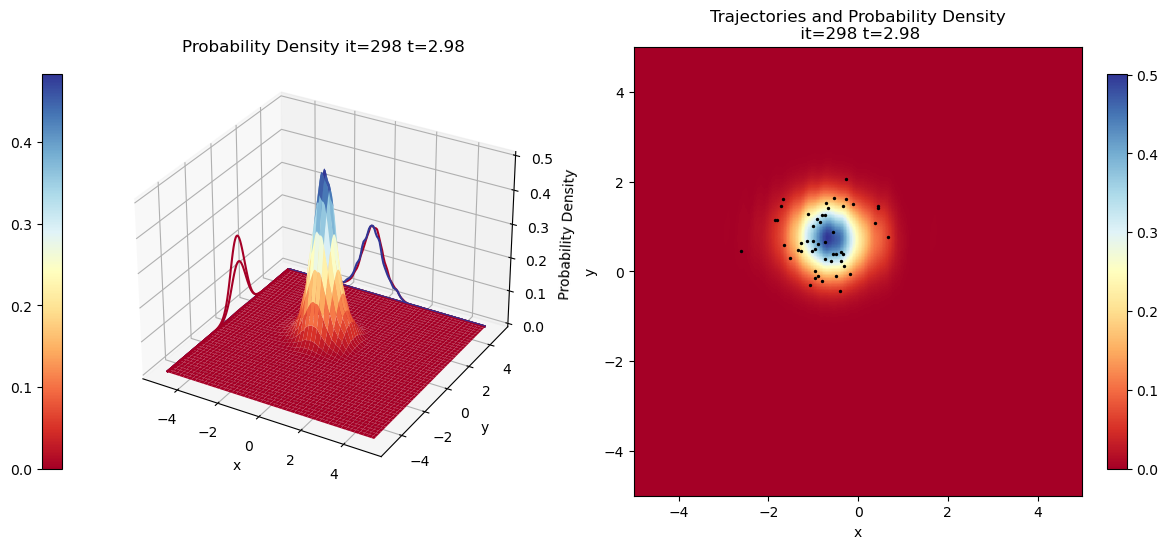

In [11]:
os.makedirs(f"./OUTPUTS/{exp_name}/figs/", exist_ok=True)
image_paths = []
dpi = 100

every=1 # Only take one data point every this number in each axis to plot
grid=np.array(np.meshgrid(*nodes)).swapaxes(-2,-1)[:,::every, ::every] #[2,Nx::ev,Ny]
print(grid.shape)
print(f"Using a mesh in the plot of {grid.shape}")
traj_cs=np.arange(len(trajs))/len(trajs)
fig = plt.figure( figsize=(14,7))

for it, t in enumerate(ts):
    if it%outputEvery==0:
        print(f"\n > It {it}/{numIts}")
        fig.clf()
        pdf = np.load(f"./OUTPUTS/{exp_name}/pdf/pdf_it_{it}_numIts_{numIts}_dt_{dt:.3}.npy")
        trajs = np.load(f"./OUTPUTS/{exp_name}/trajs/trajs_it_{it}_numIts_{numIts}_dt_{dt:.3}.npy")
        
        ax = fig.add_subplot(121, projection='3d')
        maxim = pdf.max()
        minim = pdf.min()
        # PDF ############################################################
        colormap = ax.plot_surface(grid[0], grid[1], pdf, rcount=50, ccount=50,
                cmap='RdYlBu')
        fig.colorbar(colormap, fraction=0.04, location='left')
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("Probability Density")
        ax.set_title(f"Probability Density it={it} t={t:.4}")
        cset = ax.contour(grid[0], grid[1], pdf, 7, zdir='x', 
                          offset=xlowers[0,0], cmap='RdYlBu', vmax=maxim, vmin=minim)
        cset = ax.contour(grid[0], grid[1], pdf, 7, zdir='y',
                          offset=xuppers[0,1], cmap='RdYlBu', vmax=maxim, vmin=minim)
       
        # PDF + TRAJECTORIES ##############################################
        ax = fig.add_subplot(122)
        colormap = ax.imshow(pdf.T, 
             extent=[xlowers[0,0], xuppers[0,0], xlowers[0,1], xuppers[0,1]]
                             , origin='lower',cmap='RdYlBu')
        #plt.axis(aspect='image');
        fig.colorbar(colormap, fraction=0.04, location='right')
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_title(f"Trajectories and Probability Density\n it={it} t={t:.4}")
        ax.scatter(trajs[:,0], trajs[:,1], c="black", s=2,alpha=1)
        
        image=f"./OUTPUTS/{exp_name}/figs/it_{it}.png"
        plt.savefig(image, dpi=dpi)
        image_paths.append(image)      
        
        


Generate gif

In [12]:
import imageio
fps=5
images_for_animation = [ imageio.v2.imread(image_path) for image_path in image_paths]
imageio.mimsave(f'./OUTPUTS/{exp_name}/CN_TISE_{exp_name}.gif', images_for_animation, duration=fps**-1*len(images_for_animation))

Erase png

In [13]:
#for image_path in image_paths:
#    os.remove(image_path)